### Using Real and Complex-Valued Neural Network Architectures

Now I will use deep learning algorithms to observe how the architectures and feature sizes affects the overall performance for each model. The objective is to validate by a group of experiments the following hypothesis:

**Hypotesis 1**: Complex-Valued or Quaternion-Valued networks perform better than Real-Valued ones. 

**Hypotesis 2**: Using MFCCs is better than Averaged MFCCs with 12 or 40 mel bins. 

**Hypotesis 3**: Combining some time or frequency features like *energy*, *spectral centroids* or *zero crossing rate* improves the performance. 

**Hypotesis 4**: Combining models from different natures improves the individual performance of deep learning or machine learning models. 

#### For complex-valued and quaternion-valued networks we need this libraries

In [30]:
# Install from PyPI
#!pip install torchaudio==0.8.1 #Temporary (until pytorch 0.9 is supported in Colab)
#!pip install speechbrain
import speechbrain
import torchaudio
import numpy as np

In [31]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

#### Loading averaged MFCCs

In [32]:
# open file in read mode and read data 
filename = '../processed_data/mfccs_big_and_small.npy'
with open(filename, 'rb') as f:
    Xb = np.load(f)
    yb = np.load(f)
    Xs = np.load(f)
    ys = np.load(f)
    Xbl = np.load(f)
    ybl = np.load(f)
    Xsl = np.load(f)
    ysl = np.load(f)
# Check that we've recovered the right data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')
print(f'Xb:{Xbl.shape}, yb:{ybl.shape}')
print(f'Xs:{Xsl.shape}, ys:{ysl.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)
Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


In [33]:
np.unique(ysl)

array([1, 2, 3, 4, 5, 6, 7, 8])

#### For the real architecture we need the following libraries

In [34]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization, ELU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

### Comparing two different Architectures

For example in the work of Keunwoo Choi (2018) he used a minimal convolutional architecture, one by using just conv nets and other with RNN and mel-spectrograms. Here you can find the [Link](https://github.com/keunwoochoi/music-auto_tagging-keras).

<img src="image.png" width="400" height="400">

### Equivalent model but using one-dimensional convolutions

In this first group of experiment I'll compare two architectures the same proposed by Choi and a "one-dimensional" version of the same architectures, in order to observe the relevance of time in the MFCCS (not with mel-spectrograms)

In the original work he uses 96 mel bands , hop_len = 256, n_fft = 512 and sample_rate = 12000 (in our cae we will use a bigger sample_rate)

### 1D Choi Model (2018) used to audio emotion recognition

In [40]:
model_0 = Sequential()
model_0.add(BatchNormalization(axis = 1,input_shape=(40,1), name = "batchnorm_1"))

model_0.add(Conv1D(64, 5,padding='same', name="conv1_1"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))

model_0.add(Conv1D(128, 5,padding='same', name="conv1_2"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))

model_0.add(Conv1D(128, 5,padding='same', name="conv1_3"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))


model_0.add(Conv1D(128, 5,padding='same',name="conv1_4"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=4,strides=1, padding='same'))

model_0.add(Conv1D(64, 5,padding='same',name="conv1_5"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=8,strides=4, padding='same'))

model_0.add(Flatten())
model_0.add(Dense(8))
model_0.add(Activation('softmax'))
opt0 = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [41]:
model_0.build()
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batchnorm_1 (BatchNormalizat (None, 40, 1)             160       
_________________________________________________________________
conv1_1 (Conv1D)             (None, 40, 64)            384       
_________________________________________________________________
elu_5 (ELU)                  (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 40, 64)            0         
_________________________________________________________________
conv1_2 (Conv1D)             (None, 40, 128)           41088     
_________________________________________________________________
elu_6 (ELU)                  (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 40, 128)          

### Compiling and Training Both Models

By using the 40 mel bands without augmentation.

In [10]:
model_0.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt0,
              metrics=['accuracy'])

In [42]:
model_0_v1 = tensorflow.keras.models.clone_model(model_0)

#### Splitting the data 

In [6]:
from sklearn.model_selection import train_test_split

In [13]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.10, random_state=42)

In [14]:
x_traincnn_b = np.expand_dims(X_train_b, axis=2)
x_testcnn_b = np.expand_dims(X_test_b, axis=2)
y_train_b = (y_train_b - 1).astype(int)
y_test_b = (y_test_b - 1).astype(int)

In [28]:
print(x_traincnn_b.shape)

(1296, 40, 1)


#### ```model_0```history

In [15]:
cnnhistory=model_0.fit(x_traincnn_b, np.array(y_train_b), batch_size=16, epochs=204, validation_data=(x_testcnn_b, np.array(y_test_b)))

Epoch 1/204
81/81 [==============================] - 3s 19ms/step - loss: 2.0075 - accuracy: 0.1790 - val_loss: 1.8557 - val_accuracy: 0.3333
Epoch 2/204
81/81 [==============================] - 1s 16ms/step - loss: 1.9444 - accuracy: 0.2176 - val_loss: 1.8294 - val_accuracy: 0.3750
Epoch 3/204
81/81 [==============================] - 1s 16ms/step - loss: 1.9063 - accuracy: 0.2546 - val_loss: 1.7950 - val_accuracy: 0.3681
Epoch 4/204
81/81 [==============================] - 1s 16ms/step - loss: 1.8885 - accuracy: 0.2654 - val_loss: 1.7723 - val_accuracy: 0.3264
Epoch 5/204
81/81 [==============================] - 1s 15ms/step - loss: 1.8685 - accuracy: 0.2785 - val_loss: 1.7662 - val_accuracy: 0.2986
Epoch 6/204
81/81 [==============================] - 1s 16ms/step - loss: 1.8399 - accuracy: 0.2855 - val_loss: 1.7351 - val_accuracy: 0.3403
Epoch 7/204
81/81 [==============================] - 1s 16ms/step - loss: 1.8217 - accuracy: 0.3025 - val_loss: 1.7406 - val_accuracy: 0.3542
Epoch 

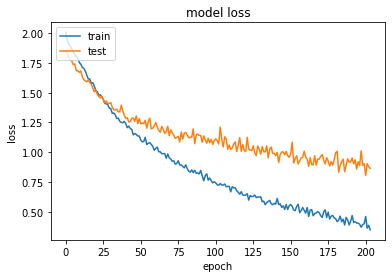

In [17]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

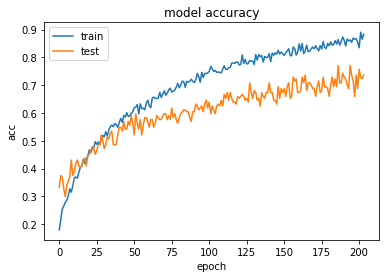

In [18]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
predictions=model_0.predict(x_testcnn_b) 
classes_x=np.argmax(predictions,axis=1)

In [20]:
from sklearn.metrics import classification_report
report = classification_report(y_test_b,classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.77      0.92      0.84        25
           2       0.60      0.63      0.62        19
           3       0.58      0.58      0.58        12
           4       0.81      0.72      0.76        18
           5       0.71      0.83      0.77        18
           6       0.78      0.78      0.78        18
           7       0.93      0.56      0.70        25

    accuracy                           0.74       144
   macro avg       0.73      0.74      0.73       144
weighted avg       0.75      0.74      0.73       144



In [21]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_b, classes_x)
print (matrix)

[[ 8  1  0  0  0  0  0  0]
 [ 1 23  0  1  0  0  0  0]
 [ 0  1 12  2  2  1  1  0]
 [ 1  3  0  7  0  1  0  0]
 [ 0  1  1  0 13  0  2  1]
 [ 0  0  2  1  0 15  0  0]
 [ 1  1  2  0  0  0 14  0]
 [ 1  0  3  1  1  4  1 14]]


In [22]:
loss, acc = model_0.evaluate(x_testcnn_b, np.asarray(y_test_b))
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

5/5 [==============================] - 0s 11ms/step - loss: 0.8648 - accuracy: 0.7361
Restored model, accuracy: 73.61%


### Same model with data augmentation

In [7]:
filename = '../processed_data/MFCCs_AUGMENTED_48.npy'
# open file in write mode and write data
with open(filename, 'rb') as f:
    F12 = np.load(f)
    F40 = np.load(f)
    Y = np.load(f)

In [8]:
X_train_aug_12, X_test_aug_12, y_train_aug_12, y_test_aug_12 = train_test_split(F12, Y, test_size=0.20, random_state=42)

In [45]:
X_train_aug_40, X_test_aug_40, y_train_aug_40, y_test_aug_40 = train_test_split(F40, Y, test_size=0.20, random_state=42)

In [46]:
x_traincnn_s_40 = np.expand_dims(X_train_aug_40, axis=2)
x_testcnn_s_40 = np.expand_dims( X_test_aug_40, axis=2)
y_train_s_40 = (y_train_aug_40 - 1).astype(int)
y_test_s_40 = ( y_test_aug_40 - 1).astype(int)

In [47]:
print(x_traincnn_s_40.shape)
print(x_testcnn_s_40.shape)

(4608, 40, 1)
(1152, 40, 1)


#### ```model_0_v1```history with data augmentation: using 40 mel bands

In [48]:
model_0_v1.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt0,
              metrics=['accuracy'])

In [49]:
cnnhistory_v1=model_0_v1.fit(x_traincnn_s_40, y_train_s_40, batch_size=16, epochs=204, validation_data=(x_testcnn_s_40,y_test_s_40))

Epoch 1/204
288/288 [==============================] - 6s 17ms/step - loss: 1.9655 - accuracy: 0.2287 - val_loss: 1.8651 - val_accuracy: 0.2865
Epoch 2/204
288/288 [==============================] - 6s 21ms/step - loss: 1.8645 - accuracy: 0.2923 - val_loss: 1.7832 - val_accuracy: 0.3359
Epoch 3/204
288/288 [==============================] - 5s 17ms/step - loss: 1.7927 - accuracy: 0.3316 - val_loss: 1.7184 - val_accuracy: 0.3767
Epoch 4/204
288/288 [==============================] - 5s 17ms/step - loss: 1.7347 - accuracy: 0.3559 - val_loss: 1.6477 - val_accuracy: 0.3993
Epoch 5/204
288/288 [==============================] - 6s 19ms/step - loss: 1.6818 - accuracy: 0.3852 - val_loss: 1.6064 - val_accuracy: 0.4366
Epoch 6/204
288/288 [==============================] - 5s 18ms/step - loss: 1.6322 - accuracy: 0.4067 - val_loss: 1.5456 - val_accuracy: 0.4583
Epoch 7/204
288/288 [==============================] - 5s 17ms/step - loss: 1.5820 - accuracy: 0.4169 - val_loss: 1.4965 - val_accuracy:

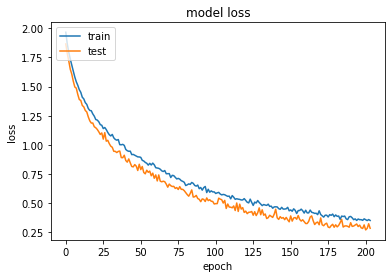

In [50]:
plt.plot(cnnhistory_v1.history['loss'])
plt.plot(cnnhistory_v1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

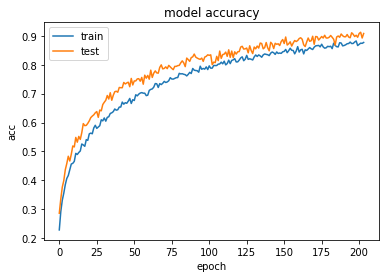

In [51]:
plt.plot(cnnhistory_v1.history['accuracy'])
plt.plot(cnnhistory_v1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
predictions=model_0_v1.predict(x_testcnn_s_40) 
classes_x=np.argmax(predictions,axis=1)

In [53]:
report = classification_report(y_test_s_40,classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        66
           1       0.96      0.97      0.96       153
           2       0.91      0.91      0.91       153
           3       0.91      0.88      0.89       178
           4       0.92      0.93      0.92       152
           5       0.91      0.84      0.88       147
           6       0.89      0.90      0.89       154
           7       0.94      0.91      0.92       149

    accuracy                           0.91      1152
   macro avg       0.90      0.91      0.90      1152
weighted avg       0.91      0.91      0.91      1152



In [54]:
matrix = confusion_matrix(y_test_s_40, classes_x)
print (matrix)

[[ 64   1   0   1   0   0   0   0]
 [  4 148   0   0   0   0   1   0]
 [  1   1 139   4   1   3   2   2]
 [  8   1   3 156   2   3   3   2]
 [  0   1   3   1 141   1   5   0]
 [  2   0   2   5   6 124   4   4]
 [  3   2   4   2   2   1 139   1]
 [  2   0   1   2   2   4   3 135]]


In [57]:
loss, acc = model_0_v1.evaluate(x_testcnn_s_40, y_test_s_40)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

36/36 [==============================] - 0s 8ms/step - loss: 0.2846 - accuracy: 0.9080
Restored model, accuracy: 90.80%


#### **Observation**: el modelo alcanza un resultado de alta acuracia sin necesidad de realizar el aumento de features. Este modelo utiliza vectores en 1D. Veamos que ocurre para la misma arquitectura utilizando apenas 12 bandas mel. 

¿Qué tan preponderante es el número de mels en la capacidad de separar un espacio de "emociones" los modelos deep learning de 1D? 

In [35]:
from sklearn.utils.class_weight import compute_class_weight

In [36]:
model_0_12 = Sequential()
model_0_12.add(BatchNormalization(axis = 1,input_shape=(12,1), name = "batchnorm_1"))

model_0_12.add(Conv1D(64, 5,padding='same', name="conv1_1"))
model_0_12.add(ELU())
model_0_12.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))

model_0_12.add(Conv1D(128, 5,padding='same', name="conv1_2"))
model_0_12.add(ELU())
model_0_12.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))

model_0_12.add(Conv1D(128, 5,padding='same', name="conv1_3"))
model_0_12.add(ELU())
model_0_12.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))


model_0_12.add(Conv1D(128, 5,padding='same',name="conv1_4"))
model_0_12.add(ELU())
model_0_12.add(MaxPooling1D(pool_size=4,strides=1, padding='same'))

model_0_12.add(Conv1D(64, 5,padding='same',name="conv1_5"))
model_0_12.add(ELU())
model_0_12.add(MaxPooling1D(pool_size=8,strides=4, padding='same'))

model_0_12.add(Flatten())
model_0_12.add(Dense(8))
model_0_12.add(Activation('softmax'))
opt0_12 = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [37]:
model_0_12.build()
model_0_12.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batchnorm_1 (BatchNormalizat (None, 12, 1)             48        
_________________________________________________________________
conv1_1 (Conv1D)             (None, 12, 64)            384       
_________________________________________________________________
elu_10 (ELU)                 (None, 12, 64)            0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
conv1_2 (Conv1D)             (None, 12, 128)           41088     
_________________________________________________________________
elu_11 (ELU)                 (None, 12, 128)           0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 12, 128)          

In [38]:
model_0_12.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt0_12,
              metrics=['accuracy'],weighted_metrics=['accuracy'])

In [39]:
x_traincnn_s_12 = np.expand_dims(X_train_aug_12, axis=2)
x_testcnn_s_12 = np.expand_dims( X_test_aug_12, axis=2)
y_train_s_12 = (y_train_aug_12 - 1).astype(int)
y_test_s_12 = ( y_test_aug_12 - 1).astype(int)

In [40]:
cls_weights = compute_class_weight('balanced', classes = np.unique(y_train_s_12),y = y_train_s_12)
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1], 2: cls_weights[2], 3: cls_weights[3], 4: cls_weights[4], 5: cls_weights[5], 6: cls_weights[6], 7: cls_weights[7]}

In [41]:
cnnhistory_12=model_0_12.fit(x_traincnn_s_12,y_train_s_12 , batch_size=16, epochs=100, validation_data=(x_testcnn_s_12,y_test_s_12),class_weight=cls_weight_dict)

Epoch 1/100
288/288 [==============================] - 4s 11ms/step - loss: 1.9704 - accuracy: 0.2144 - weighted_accuracy: 0.2134 - val_loss: 1.8758 - val_accuracy: 0.3090 - val_weighted_accuracy: 0.3090
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 1.8577 - accuracy: 0.2914 - weighted_accuracy: 0.2881 - val_loss: 1.7411 - val_accuracy: 0.3672 - val_weighted_accuracy: 0.3672
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 1.7622 - accuracy: 0.3398 - weighted_accuracy: 0.3382 - val_loss: 1.6475 - val_accuracy: 0.4019 - val_weighted_accuracy: 0.4019
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 1.7008 - accuracy: 0.3553 - weighted_accuracy: 0.3537 - val_loss: 1.5853 - val_accuracy: 0.4245 - val_weighted_accuracy: 0.4245
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 1.6599 - accuracy: 0.3813 - weighted_accuracy: 0.3774 - val_loss: 1.5509 - val_accuracy: 0.4332 - val_weighted_

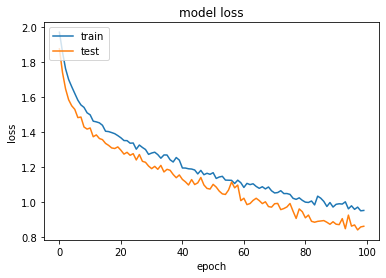

In [42]:
plt.plot(cnnhistory_12.history['loss'])
plt.plot(cnnhistory_12.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

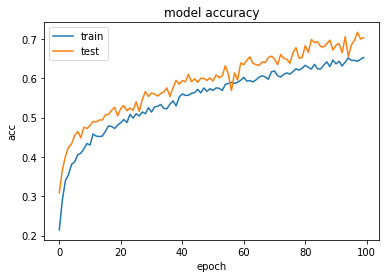

In [43]:
plt.plot(cnnhistory_12.history['accuracy'])
plt.plot(cnnhistory_12.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
predictions=model_0_12.predict(x_testcnn_s_12) 
classes_x=np.argmax(predictions,axis=1)
report = classification_report(y_test_s_12,classes_x)
print(report)
matrix = confusion_matrix(y_test_s_12, classes_x)
print(matrix)
loss, acc = model_0_12.evaluate(x_testcnn_s_12, y_test_s_12)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

NameError: name 'classification_report' is not defined